In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

# Simulation Setup
Simulation of a microring resonator demultiplexer / filter. 
Consists of a ring resonator in the center, a bottom waveguide containing a mode source and the through port, and a top waveguide containing the drop port.

In [3]:
# ring resonator device parameters
wg_height = 0.220 # height of the waveguide (um)
wg_width = 0.420 # width of the waveguide (um)
radius = 2.04958 # radius of the ring resonator (um)
gap = 0.140 # gap between the ring resonator and the straight waveguides (um)
gap2 = 0.500 #gap between the rings

In [4]:
# permittivity of the waveguide and substrate at 1550nm
si_eps = 12.085
sio2_eps = 2.0852

# wavelength (in um) and frequency (in Hz)
lambda_range = (1.53, 1.565) # corresponding to the C-band (1.53 to 1.565)
lambda0 = np.sum(lambda_range)/2
freq_range = (td.C_0 / lambda_range[1], td.C_0 / lambda_range[0])
freq0 = td.C_0 / lambda0
freqw = freq_range[1] - freq_range[0]

# frequencies and wavelengths of monitor
Nfreq = 2000
monitor_lambdas = np.linspace(lambda_range[0], lambda_range[1], Nfreq)
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)

# spacing between the waveguide and the PML
spacing = 0.8 #um

# simulation domain and total run time
sim_size = (2*(radius + wg_width/2 + spacing), 2*spacing + 2*gap + 4*wg_width + 4*radius + gap2, wg_height + 2*spacing)
run_time = 20000/freq0
print("Run Time =", run_time)

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl = 20, wavelength = lambda0)

# waveguide, substrate, and air material
mat_wg = td.Medium(
    permittivity = si_eps,
    name = "silicon",
)
mat_substrate = td.Medium(
    permittivity = sio2_eps,
    name = "silica",
)

# ring resonator
ring1_outer = td.Structure(
    geometry = td.Cylinder(
        center = [0, -sim_size[1]/2 + spacing + wg_width + gap + wg_width/2 + radius, 0],
        radius = radius + wg_width/2,
        length = wg_height,
    ),
    medium = mat_wg,
    name = "Outer Ring 1",
)
ring1_inner = td.Structure(
    geometry = td.Cylinder(
        center = [0, -sim_size[1]/2 + spacing + wg_width + gap + wg_width/2 + radius, 0],
        radius = radius - wg_width/2,
        length = wg_height,
    ),
    medium = mat_substrate,
    name = "Inner Ring 1",
)
ring2_outer = td.Structure(
    geometry = td.Cylinder(
        center = [0, sim_size[1]/2 - spacing - wg_width - gap - wg_width/2 - radius, 0],
        radius = radius + wg_width/2,
        length = wg_height,
    ),
    medium = mat_wg,
    name = "Outer Ring 2",
)
ring2_inner = td.Structure(
    geometry = td.Cylinder(
        center = [0, sim_size[1]/2 - spacing - wg_width - gap - wg_width/2 - radius, 0],
        radius = radius - wg_width/2,
        length = wg_height,
    ),
    medium = mat_substrate,
    name = "Inner Ring 2",
)

# top and bottom waveguides
waveguide_top = td.Structure(
    geometry = td.Box(
        center = [0, sim_size[1]/2 - spacing - wg_width/2, 0],
        size = [td.inf, wg_width, wg_height],
    ),
    medium = mat_wg,
    name = "Top Waveguide"
)
waveguide_bottom = td.Structure(
    geometry = td.Box(
        center = [0, -sim_size[1]/2 + spacing + wg_width/2, 0],
        size = [td.inf, wg_width, wg_height],
    ),
    medium = mat_wg,
    name = "Bottom Waveguide"
)

# xy-plane frequency-domain field monitor at central frequency
field_mnt = td.FieldMonitor(
    center = [0,0,0],
    size = [np.inf, np.inf, 0],
    freqs = [td.C_0/1.550997178],
    name = "Field",
)

# through port flux monitor
flux_mnt_through = td.FluxMonitor(
    center = [sim_size[0]/2 - spacing, -sim_size[1]/2 + spacing + wg_width/2, 0],
    size = [0, 4 * wg_width, 6 * wg_height],
    freqs = monitor_freqs,
    name = "Flux Monitor (Through Port)"
)

# drop port flux monitor
flux_mnt_drop = td.FluxMonitor(
    center = [sim_size[0]/2 - spacing, sim_size[1]/2 - spacing - wg_width/2, 0],
    size = [0, 4 * wg_width, 6 * wg_height],
    freqs = monitor_freqs,
    name = "Flux Monitor (Drop Port)",
    normal_dir = "+"
)

# simulation
sim = td.Simulation(
    size = sim_size,
    grid_spec = grid_spec,
    symmetry = [0, 0, 1],
    structures = [ring1_outer, ring1_inner, ring2_outer, ring2_inner, waveguide_top, waveguide_bottom],
    medium = mat_substrate,
    sources = [],
    monitors = [flux_mnt_through, flux_mnt_drop],
    run_time = run_time,
    shutoff = 1e-7,
    boundary_spec = td.BoundarySpec.all_sides(boundary = td.PML())
)

sim.plot_3d()

Run Time = 1.0323808746382806e-10


# Source Setup
Define a mode source that launches the TE0 mode into the input waveguide.

In [5]:
# position and size of source plane
source_plane = td.Box(
    center = (-sim_size[0]/2 + spacing, -sim_size[1]/2 + spacing + wg_width/2, 0),
    size = (0, 4 * wg_width, 6 * wg_height)
)

# number of modes to solve
num_modes = 1

# setup and solve for modes
mode_spec = td.ModeSpec(num_modes = num_modes, group_index_step = True, target_neff = 3.48, filter_pol = 'te')
ms = ModeSolver(simulation = sim, plane = source_plane, mode_spec = mode_spec, freqs = [freq0])
mode_data = ms.solve()

print("Effective index of computed modes: ", np.array(mode_data.n_eff))
print("Group index of computed modes: ", np.array(mode_data.n_group))

07:47:23 GMT Standard Time WARNING: Use the remote mode solver with subpixel    
                           averaging for better accuracy through                
                           'tidy3d.plugins.mode.web.run(...)'.                  

Effective index of computed modes:  [[2.40462923]]
Group index of computed modes:  [[4.20640612]]


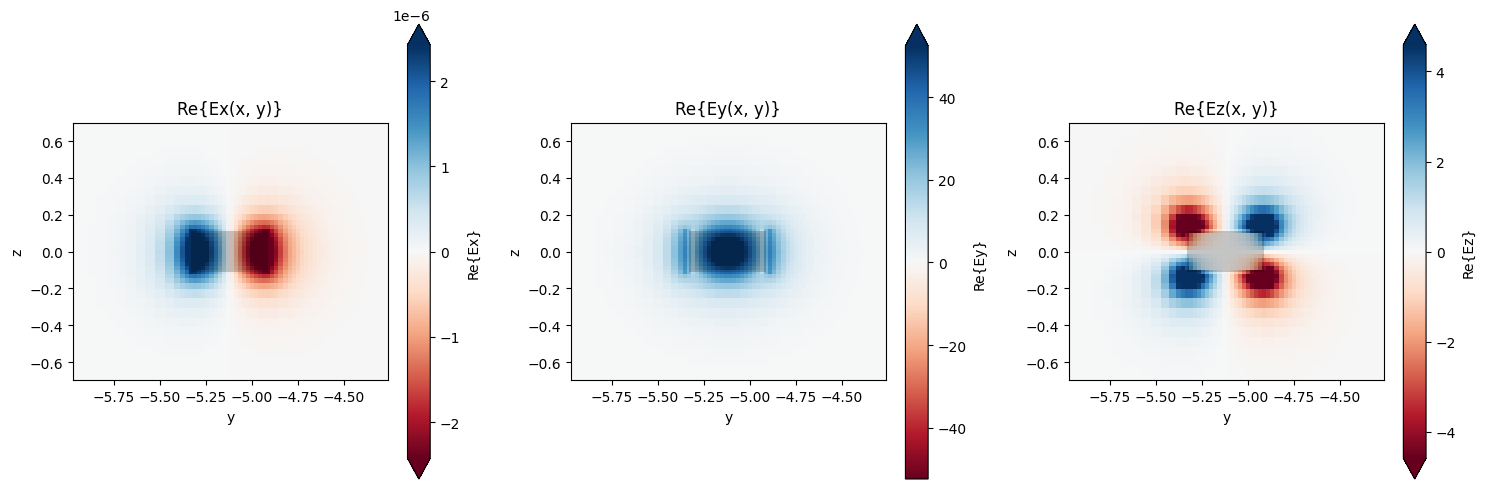

In [6]:
# visualise the mode
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), tight_layout = True)
ms.plot_field("Ex", "real", f = freq0, mode_index = 0, ax = ax1)
ms.plot_field("Ey", "real", f = freq0, mode_index = 0, ax = ax2)
ms.plot_field("Ez", "real", f = freq0, mode_index = 0, ax = ax3)
ax1.set_title("Re{Ex(x, y)}")
ax2.set_title("Re{Ey(x, y)}")
ax3.set_title("Re{Ez(x, y)}")
plt.show()

# add mode source at the input of the waveguide
source_time = td.GaussianPulse(freq0 = freq0, fwidth = 0.5*freqw)
mode_source = ms.to_source(mode_index = 0, direction = "+", source_time = source_time)

sim = sim.copy(update = {"sources" : [mode_source]})

# Plot Simulation Setup

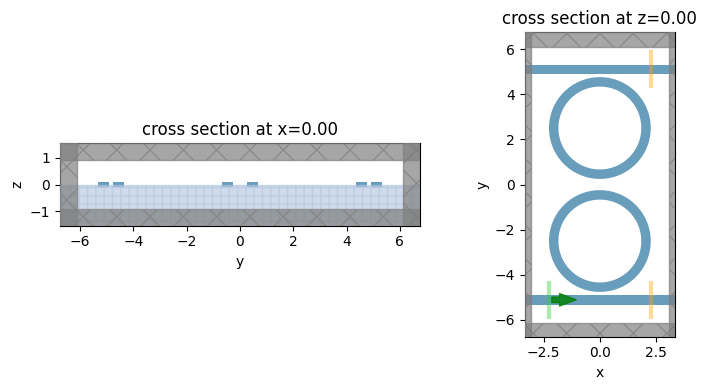

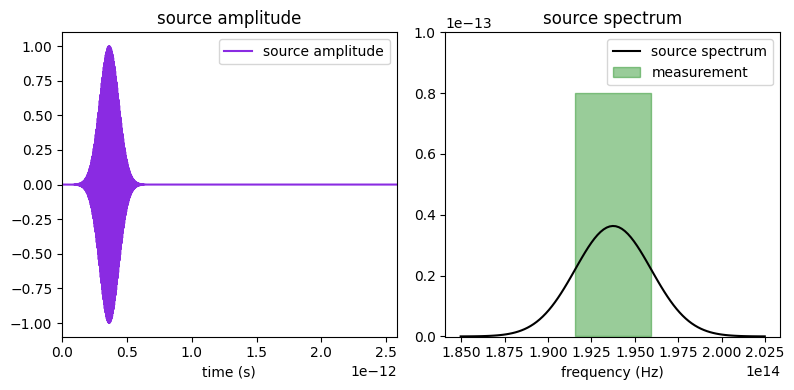

In [7]:
fig, ax = plt.subplots(1, 2, tight_layout = True, figsize = (8,4))
sim.plot(x = 0, ax = ax[0]);
sim.plot(z = 0, ax = ax[1]);
plt.show()

# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
plot_time = run_time/40
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, plot_time, 10000), ax=ax1)
ax1.set_xlim(0, plot_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 100000), val = 'abs', ax=ax2)
fill_max = 80e-15
ymax = 100e-15
ax2.fill_between(freq_range, [0,0], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

sim.plot_3d()



In [13]:
# initializes job, puts task on server (but doesnt run it)
job = web.Job(simulation=sim, task_name="second_order_500nm", verbose=True)

# estimate the maximum cost
estimated_cost = web.estimate_cost(job.task_id)

15:22:36 GMT Standard Time WARNING: Simulation has 2.58e+06 time steps. The     
                           'run_time' may be unnecessarily large, unless there  
                           are very long-lived resonances.                      

15:22:37 GMT Standard Time Created task 'second_order_500nm' with task_id       
                           'fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b' and      
                           task_type 'FDTD'.

                           View task using web UI at                            
                           ]8;id=199597;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=851820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\taskId]8;;\]8;id=199597;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\=]8;;\]8;id=510816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\fdv]8;;\
                           ]8;id=510816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\e]8;;\]8;id=199597;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\-792017e9-5fc3-4a78-a86b-6099627ccb8b']8;;\.

Output()

15:22:40 GMT Standard Time Maximum FlexCredit cost: 4.418. Minimum cost depends 
                           on task execution details. Use                       
                           'web.real_cost(task_id)' to get the billed FlexCredit
                           cost after a simulation run.

In [14]:
sim_data = job.run(path="data/microring_baseline.hdf5")

15:22:44 GMT Standard Time status = queued

                           To cancel the simulation, use 'web.abort(task_id)' or
                           'web.delete(task_id)' or abort/delete the task in the
                           web UI. Terminating the Python script will not stop  
                           the job running on the cloud.

Output()

15:22:55 GMT Standard Time status = preprocess

15:22:58 GMT Standard Time Maximum FlexCredit cost: 4.418. Use                  
                           'web.real_cost(task_id)' to get the billed FlexCredit
                           cost after a simulation run.

                           starting up solver

                           running solver

Output()

15:30:43 GMT Standard Time early shutoff detected at 52%, exiting.

                           status = postprocess

Output()

15:30:46 GMT Standard Time status = success

15:30:47 GMT Standard Time View simulation result at                            
                           ]8;id=1078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=629033;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\taskId]8;;\]8;id=1078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\=]8;;\]8;id=371553;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\fdv]8;;\
                           ]8;id=371553;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\e]8;;\]8;id=1078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-792017e9-5fc3-4a78-a86b-6099627ccb8b\-792017e9-5fc3-4a78-a86b-6099627ccb8b']8;;\.

Output()

15:30:57 GMT Standard Time loading simulation from data/microring_baseline.hdf5

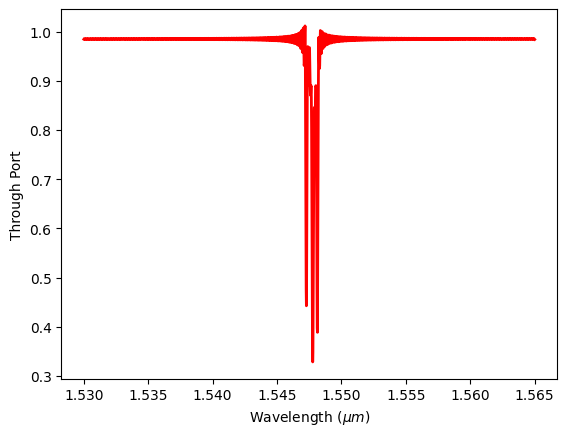

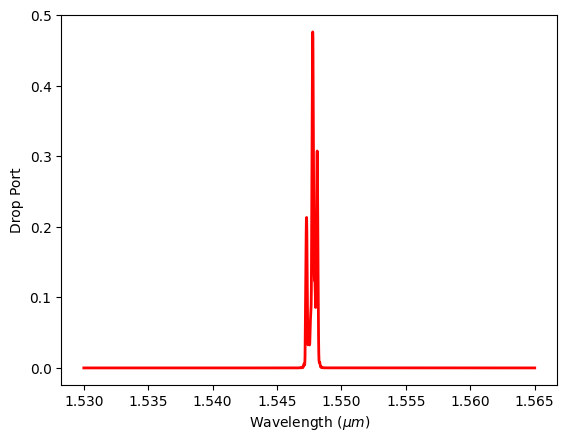

In [42]:
T1 = sim_data["Flux Monitor (Through Port)"].flux
T2 = sim_data["Flux Monitor (Drop Port)"].flux

measured_f = sim_data["Flux Monitor (Through Port)"].flux.f

plt.plot(td.C_0 / measured_f, T1, "red", linewidth=2)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Through Port")
plt.show()

plt.plot(td.C_0 / measured_f, T2, "red", linewidth=2)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Drop Port")
plt.show()
